In [2]:
!python3 -V

Python 3.10.2


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

In [5]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [6]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda du: du.total_seconds()/60)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[ns]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

/usr/local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

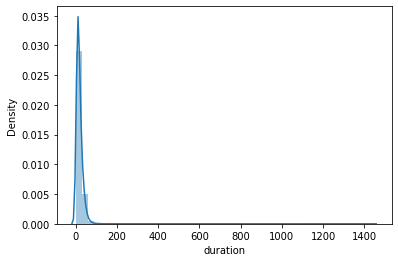

In [8]:
#checking the duration distribution
sns.distplot(df.duration)

In [9]:
df.duration.describe(percentiles=[0.97,0.98,0.99])
((df.duration >= 1) & (df.duration <=60)).mean()

0.9658903787344154

In [10]:
#Ppreparing trainig data
df = df[(df.duration >=1) & (df.duration <=60)]
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

#for one head encoding we need categorical data
df[categorical] = df[categorical].astype(str)


In [11]:
# we will use dict vectorizer for one hot encoding. for that we need the input data frame features in dictionary format

train_dict = df[categorical + numerical].to_dict(orient='records')


In [12]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
Y_train = df.duration.values

In [13]:
#linear regression model
lr = LinearRegression()
lr.fit(X_train, Y_train)

Y_predict = lr.predict(X_train)

In [20]:
#model loss calculation for linear regression model
#squared = false ie root mean squared error
mean_squared_error(Y_train,Y_predict, squared=False)

9.827368941909368

/usr/local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


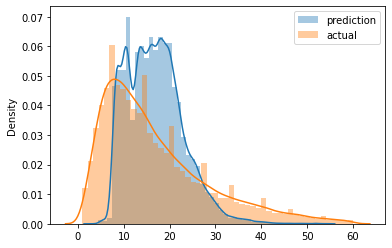

In [19]:
#plot of prediction against actual
sns.distplot(Y_predict,label='prediction')
sns.distplot(Y_train, label='actual')


plt.legend()

In [5]:
def read_dataframe(filename):
    if str(filename).endswith('csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    else:
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda du: du.total_seconds()/60)

    df = df[(df.duration >=1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [25]:
#read input data
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_test = read_dataframe('./data/green_tripdata_2021-02.parquet')


In [26]:
df_train.shape, df_test.shape

((73908, 21), (61921, 21))

In [27]:
#feature creation
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_test['PU_DO'] = df_test['PULocationID'] + '_' + df_test['DOLocationID']

In [28]:
#feature and label selection
categorical = ['PU_DO']
numerical = ['trip_distance']
target = 'duration'


In [29]:
# training and testing data set creation with one hot encoding - dict vectorization of categorical dataset with one numerical feature

train_dict = df_train[categorical + numerical].to_dict(orient='records')
test_dict = df_test[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
X_test = dv.transform(test_dict)

y_train = df_train[target].values
y_test = df_test[target].values

In [30]:
# training a linear regression model and calculate root mean square loss
lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

mean_squared_error(y_pred,y_test, squared=False)

7.758715213828063

/usr/local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


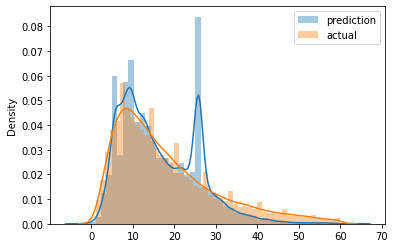

In [31]:
#plot of prediction against actual
sns.distplot(y_pred,label='prediction')
sns.distplot(y_test, label='actual')


plt.legend()

In [32]:
#saving the linear regression model for future use:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [33]:
#training a lasso model
ls = Lasso(0.01)

ls.fit(X_train, y_train)

y_pred = ls.predict(X_test)

mean_squared_error(y_pred,y_test, squared = False
)

11.167275941179728